## Introduction

The data that we have is 1000 simulated spectra of galaxies. A spectrum is a high resolution chart or graph that shows the intensity of light being emitted over a range of wavelengths. Galaxies consist of many different components, such as stars, gases, and dust. These physical properties leave a different and specific imprint on the galaxy’s spectral energy distribution. It is our hypothesis that these properties of galaxies can be determined empirically by analyzing spectral data gathered from such galaxies. We employed Machine Learning tools to determine the degree that a galaxy’s spectral energy distribution is correlated with each of the four properties being analyzed. Our results show that there exists a very strong correlation between the mass of a galaxy and its spectral energy distribution. For the dust and age properties of galaxies, a relatively strong correlation was also observed. In the case of tau, our results seem to indicate that a galaxy’s tau has little to no correlation with its spectral energy distribution. Some ways we could improve our results include using more advanced machine learning techniques and increasing the size and/or quality of our dataset.

<ipython-input-1-3e197cdf31b4>:9: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  matplotlib.rcParams['text.latex.unicode']=False


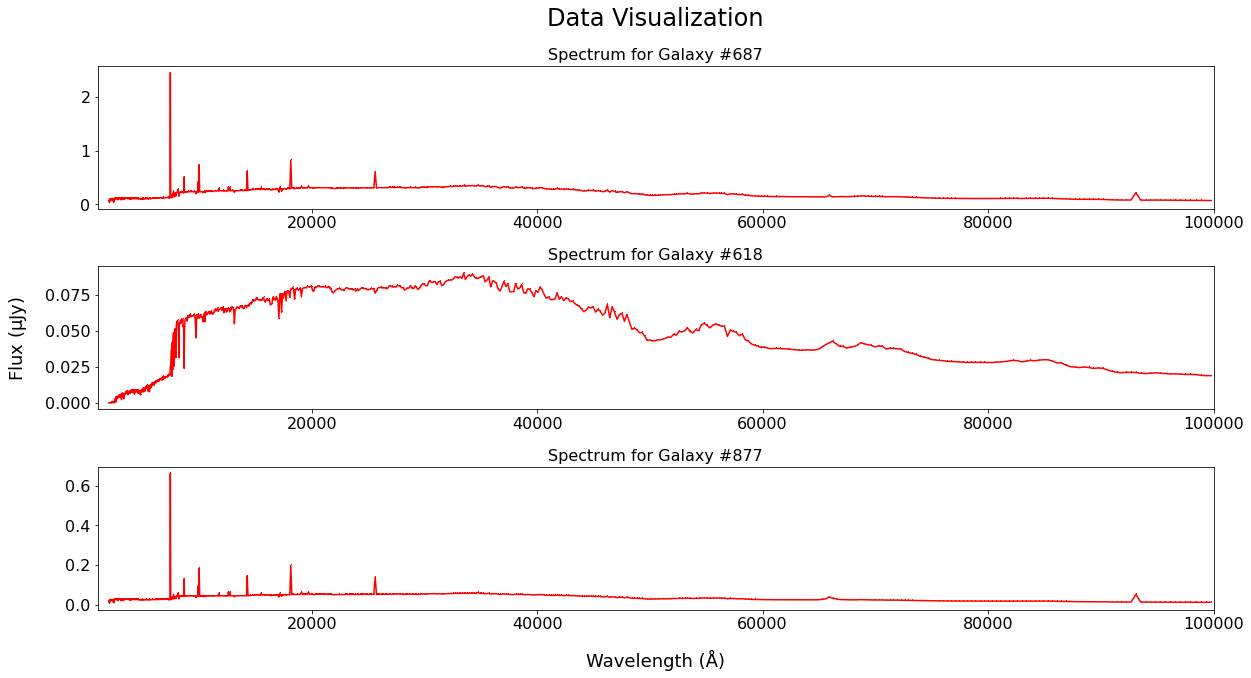

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import scipy.stats

matplotlib.rcParams['text.latex.unicode']=False
spectra = pd.read_csv('spectra.csv', delimiter=' ', header=None)
wavelengths = pd.read_csv('Wavalengths.txt', header=None)
galaxy_properties = pd.read_csv('GalaxyProperties.csv', index_col = 0)

random.seed(1010) # for reproducibility
rows = [random.randint(0, len(spectra)) for i in range(3)]  # select three random galaxy spectrums to visualize

plt.rcParams["figure.figsize"] = (20,10) #set size of plot
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

fig = plt.figure()
ax = fig.add_subplot(111) # Generating subplots for our figure; see https://stackoverflow.com/a/6981055/3135556
ax1 = fig.add_subplot(311) # 3 rows, 1 column, plot at position 1
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(wavelengths, spectra.loc[rows[0]], 'r,-')
ax2.plot(wavelengths, spectra.loc[rows[1]], 'r,-')
ax3.plot(wavelengths, spectra.loc[rows[2]], 'r,-')

ax1.set_xlim(1000, 100000) # restrict the x-axis to mitigate the gap that exists around x=0
ax2.set_xlim(1000, 100000)
ax3.set_xlim(1000, 100000)

# Set common labels
ax.set_xlabel("Wavelength (Å)", fontsize=18, labelpad=18)
ax.set_ylabel("Flux ($\mathrm{\mu}$Jy)", fontsize=18, labelpad=36)
ax.set_title("Data Visualization", fontsize=24, pad=40)

ax1.set_title("Spectrum for Galaxy #" + str(rows[0]), fontsize=16)
ax2.set_title("Spectrum for Galaxy #" + str(rows[1]), fontsize=16)
ax3.set_title("Spectrum for Galaxy #" + str(rows[2]), fontsize=16)

plt.subplots_adjust(hspace=0.4) # increase vertical distance between subplots
fig.savefig("visualization.png")

## Objectives

* Build a ML model that can predict four different physical properties using algorithm of our choice
* The four different properties are as follows: Age, Tau, Stellar Mass, and Dust
* In this project we present the use of Support Vector Machine Algorithm and Decision Trees to predict the four different properties listed above
* The performance of the Machine Learning model is measured by simulating different noise level, seeing how the results change and determining how well the model performs


## Unsuccessful Approaches

When choosing which algorithm could help us predict the desired properties, several unsuccessful attempts were made. 
Linear Regression wasn’t efficient at predicting the desired properties. 
An attempt to a Neural Network at 1,000; 100,00; and 1,000,000 runs only proved a small level of efficiency and an exponential computing time. While a much better neural network could accurately precit these properties, more experience is needed in setting up a succesful network.

## Useful Functions


In [2]:
def dtt(values, val_type='pd'):
    """
    Do The Thing -- takes the log of the sum of each row in 'values'
    Returns a NumPy array with as many values as the number of rows in 'values'
    Positional arguments:values -- a Pandas DataFrame or NumPy array
    Optional arguments: val_type -- 'pd' if 'values' is a Pandas DataFrame, 'np' if 'values' is a NumPy array
    """
    
    X = np.empty(len(values))
    
    if (val_type == 'pd'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values.iloc[i]))
    elif (val_type == 'np'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values[i]))
    else:
        raise ValueError("Expecting val_type to be either 'pd' or 'np'")
        
spectra_X = dtt(spectra) # do the thing to the spectra dataset, which will be used for visualization purposes
    
def plot_model_performance(X, y_expected, y_predicted, ylabel, **kwargs):
    """
    Plot the predicted values against the expected values. Correct predictions should result
    in overlapping data points.
    """
    
    params = {
        'actual_color': 'red',
        'predicted_color': 'blue',
        'actual_label': 'Actual values',
        'predicted_label': 'Predicted values',
        'title': 'Model Perfomance',
        'xlabel': '$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$',
        'save_fig': False,
        'save_fig_as': '',
        'scores': None,
        'scores_loc': (0.01, 0.98),
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
    
    fig, ax = plt.subplots()
    ax.scatter(X, y_expected, color=params['actual_color'], label=params['actual_label'], alpha=0.6)
    plt.scatter(X, y_predicted, color=params['predicted_color'], label=params['predicted_label'], alpha=0.6)
    ax.legend()
    ax.set_title(params['title'], fontsize=20, pad=10)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=14)
    ax.set_xlabel(params['xlabel'], fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        loc = params['scores_loc']
        ax.text(loc[0], loc[1], text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if params['save_fig']:
        if params['save_fig_as'] == '':
            params['save_fig_as'] = 'Model Performance - ' + ylabel
        fig.savefig(params['save_fig_as'], dpi=300)
        
def plot_model_training_performance(true_labels, predicted_labels, axis=None, **kwargs):
    """
    Plot true labels vs predicted labels. A perfect model should show a linear correlation
    of the type y=x.
    
    Note that the save_fig and return_plot kwargs only work if and only if the axis remains
    undefined. If an axis is passed in as an argument, the values for save_fig and return_plot
    will be ignored. You can call savefig on the axis itself as an alternative.
    """
    
    params = {
        'title': None,
        'label': '',
        'save_fig': False,
        'save_fig_as': None,
        'scores': None,
        'scores_loc': (0.01, 0.98),
        'return_plot': False,
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
      
    if params['title'] == None:
        title = params['label'] + ' Model Training Performance'
    else:
        title = params['title']
    
    if axis == None:
        fig, ax = plt.subplots()
    else:
        ax = axis
    
    ax.scatter(predicted_labels, true_labels, color='orange', s=50)
    ax.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=4) # display a straight line from lowest true value to highest true value
    ax.set_title(title.strip(), fontsize=20, pad=10)
    ax.set_ylabel('True values', fontsize=16, labelpad=14)
    ax.set_xlabel('Predicted values', fontsize=16, labelpad=14)
    
    if params['scores'] is not None:  #show training scores on graphs
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Mean Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        loc = params['scores_loc']
        ax.text(loc[0], loc[1], text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if axis == None: # only save fig or return plot if axis == None ; fig does not exist when axis is defined
        if params['save_fig']:
            if params['save_fig_as'] == None:
                params['save_fig_as'] = title
            fig.savefig(params['save_fig_as'], dpi=300)
        
        if params['return_plot']:
            return fig

In [3]:

cv = KFold(n_splits=5, shuffle=True, random_state=101) # define the cross validation to be used throughout the report

def visualize(Y, ylabel, title, X=spectra_X, xlabel='$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$', save_fig=False, save_as=None):
    """
    Plot expected labels vs flux values. Simple plot to visualize the data.
    """
    plt.scatter(X, Y)
    plt.title(title, fontsize=20, pad=10)
    plt.xlabel(xlabel, fontsize=16, labelpad=14)
    plt.ylabel(ylabel, fontsize=16, labelpad=14)
    if save_fig == True:
        if save_as == None:
            save_as = title
        plt.savefig(save_as, dpi=300)


def add_noise(df, percent):
    """
    Add a percetange of noise to a Pandas DataFrame.
    Returns a new Pandas DataFrame containing the noise.
    
    Positional arguments:
    - df : a Pandas DataFrame
    - percent: percentage of noise desired, as a float. 
               For example, a value of 0.10 is 10%. 
               Similarly a value of 1.15 is 115%. 
    """
    ndf = pd.DataFrame()
    for i in range(len(df.columns)):
        mean = df[i] * percent
        gauss_dist = scipy.stats.norm.rvs(loc=0, scale=0.005, size=1000)
        ndf[i] = df[i] + np.abs(gauss_dist)
        
    return ndf
def plot_noise_together(model, target, label, cv, scoring=['r2', 'neg_mean_squared_error']):
    """
    A plotting function for grouping together the noisy plots and no-noise plots all in one figure.
    """
    
    noisy_spectra = [{
        'spectrum': spectra_1,
        'noise': '$1\%$'
    }, {
        'spectrum': spectra_5,
        'noise': '$5\%$'
    }, {
        'spectrum': spectra_10,
        'noise': '$10\%$'
    }]
    
    plots = np.empty(3)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    reg_ax = fig.add_subplot(211) # original plot with no noise
    noisy_ax1 = fig.add_subplot(234) # 1% noise
    noisy_ax2 = fig.add_subplot(235) # 5% noise
    noisy_ax3 = fig.add_subplot(236) # 10% noise
    noisy_axes = [noisy_ax1, noisy_ax2, noisy_ax3] # add them all to one variable so it's easy to iterate over
    
    # remove ticks from the outer plot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    ax.set_title("Comparison of " + label + " Model with Varying Degrees of Noise", fontsize=24, pad=60)
    
    cv_scores = cross_validate(model, spectra, target, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True) #Regular without noise
    prediction = cross_val_predict(model, spectra, target, cv=cv, n_jobs=-1)
    estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()] #choose the estimator that gives the highest correlation

    scores = {
        '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
        'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
    }

    plot_model_training_performance(target, prediction, label=label, scores=scores, axis=reg_ax) # store the unnoisy plot in the reg_ax variable
    
    for i,val in enumerate(noisy_spectra): # get noisy plot for each noisy dataset
        spectrum =  val['spectrum']
        cv_scores = cross_validate(model, spectrum, target, cv=cv, scoring=scoring, n_jobs=-1, return_estimator=True)
        prediction = cross_val_predict(model, spectrum, target, cv=cv, n_jobs=-1)
        estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()] 
        
        scores = {
            '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
            'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
        }
        
        title = label + ' Model w/ ' + val['noise'] + ' Noise'
        plot_model_training_performance(target, prediction, label=label, title=title, scores=scores, axis=noisy_axes[i]) #store the noisy plot in the corresponding noisy axis
        
    plt.subplots_adjust(hspace=0.6) #adjust spacing between plots
    fig.savefig(label + " Noise Performance", dpi=300)

In [4]:

# Note that this cell must run after the function has been created
spectra_1 = add_noise(spectra, 0.01)
spectra_5 = add_noise(spectra, 0.05)
spectra_10 = add_noise(spectra, 0.1)

## Predicting Age

ValueError: x and y must be the same size

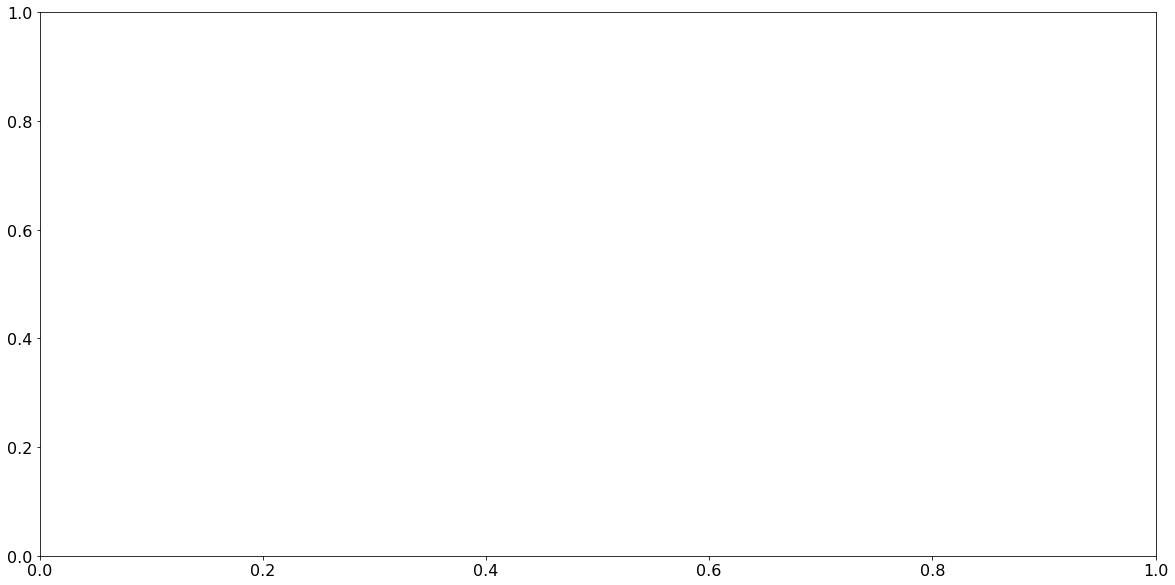

In [5]:
ages = galaxy_properties['age']
visualize(ages, 'Ages', 'Ages Visualization', save_fig=True)

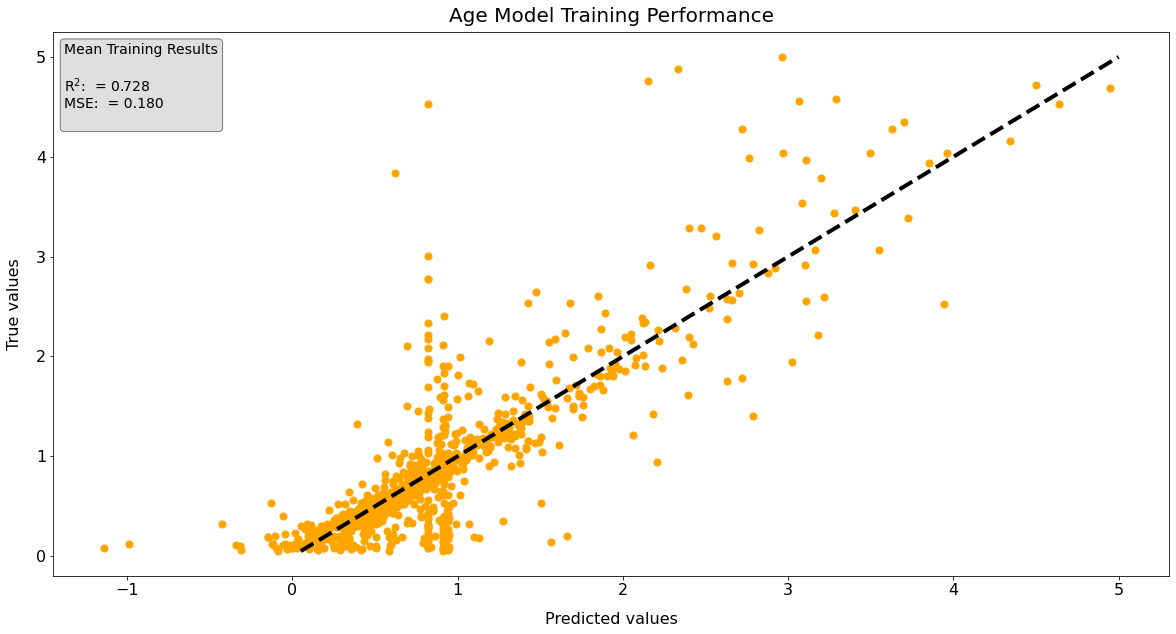

In [6]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.svm import SVR

age_model = SVR(C=2300, gamma=0.08, kernel='rbf')
cv_scores = cross_validate(age_model, spectra, ages, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(age_model, spectra, ages, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(ages, prediction, label='Age', scores=scores, save_fig=True)

ValueError: x and y must be the same size

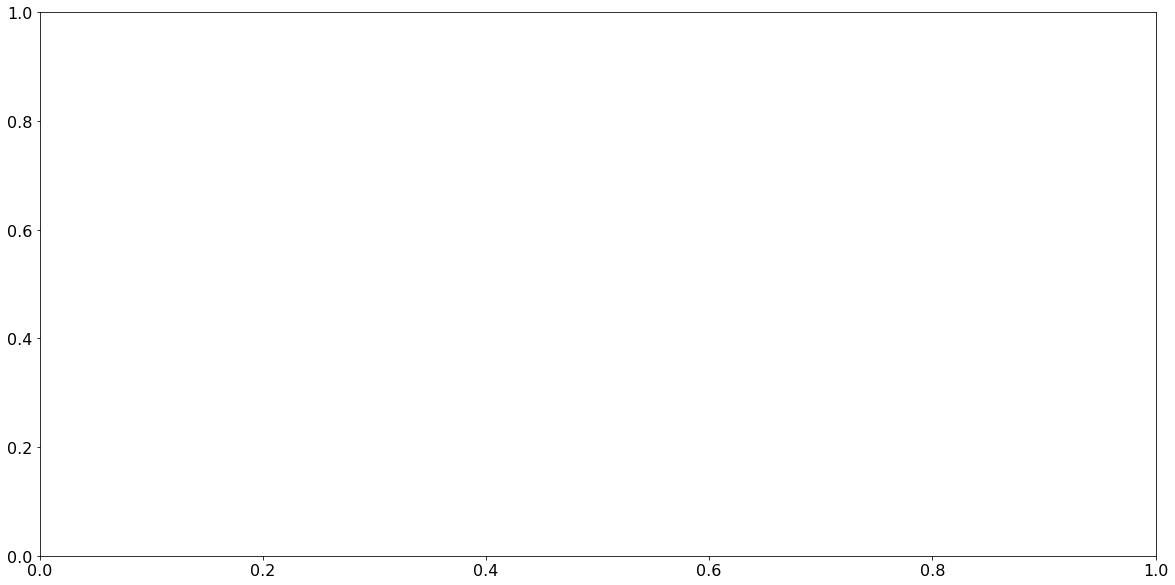

In [7]:
plot_model_performance(spectra_X, ages, estimator.predict(spectra), 'Age', scores=scores, save_fig=True)

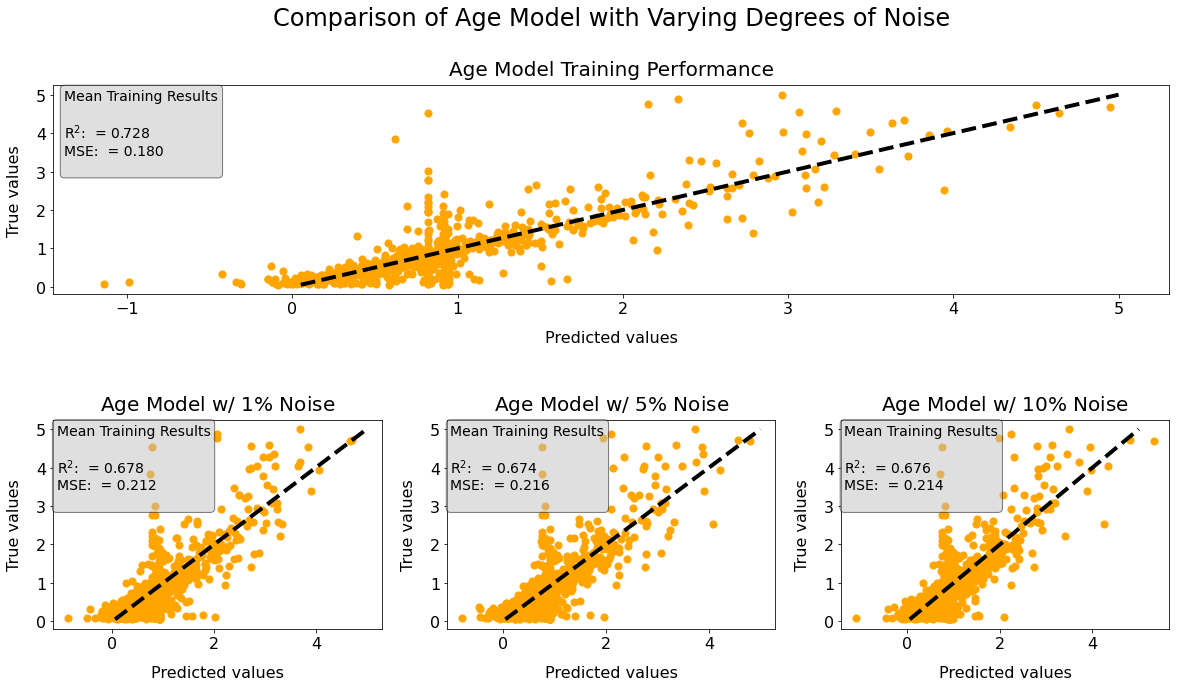

In [8]:
plot_noise_together(age_model, ages, "Age", cv)

## Predicting Tau

ValueError: x and y must be the same size

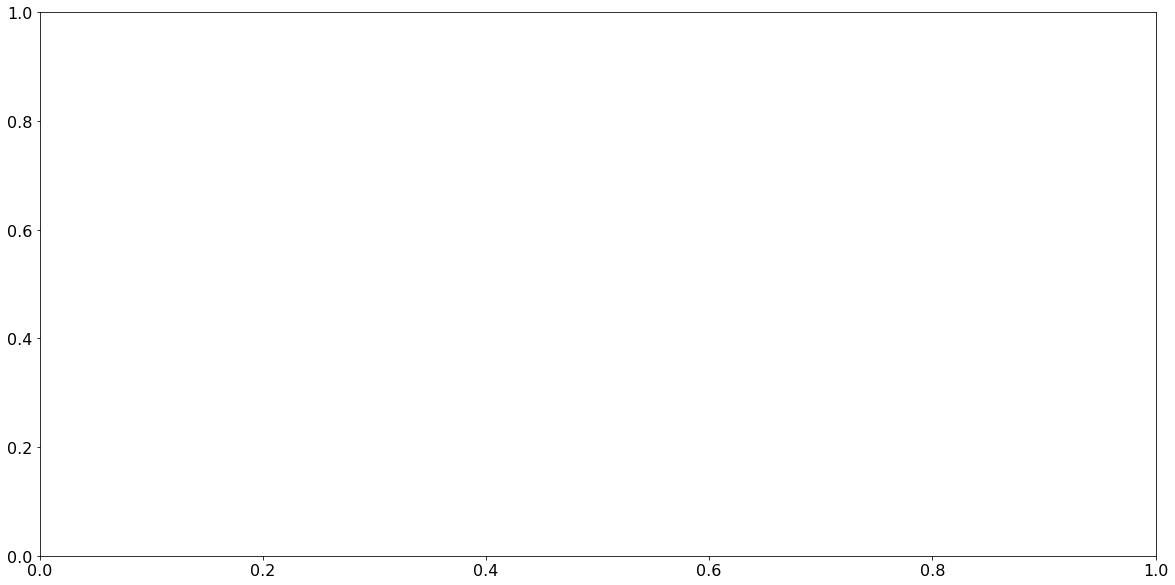

In [9]:
tau = galaxy_properties['tauGyr']
visualize(tau, 'Tau', 'Tau Visualization', save_fig=True)

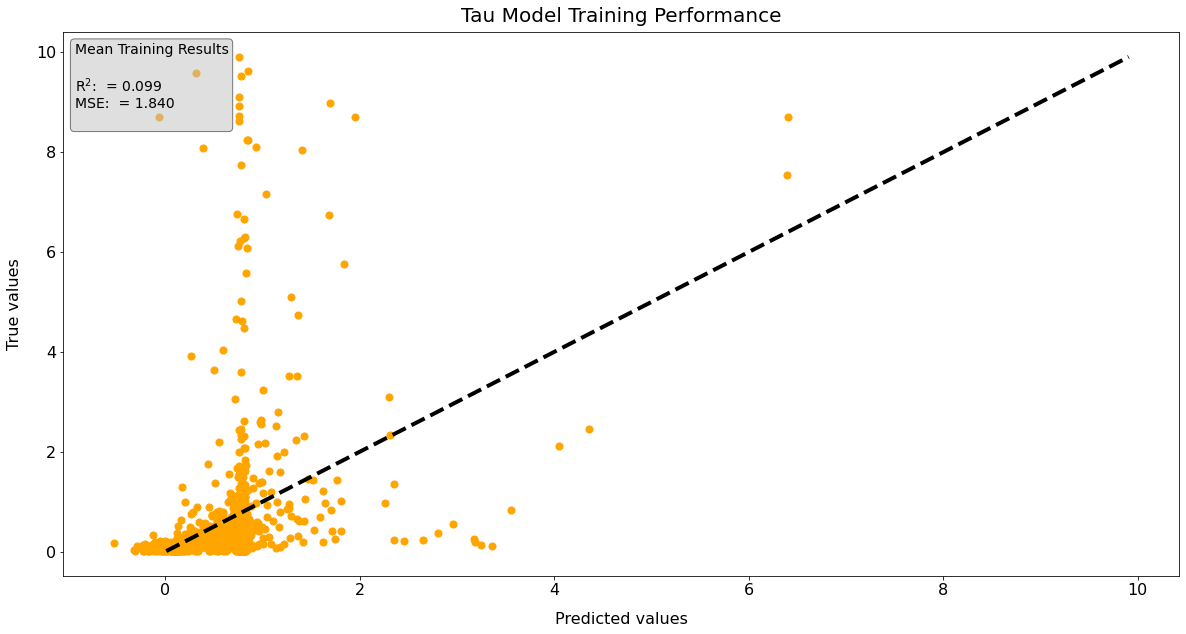

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(C=10, gamma=16, kernel='rbf')
tau_model = make_pipeline(StandardScaler(), svr) # scaling our data led to the best results
cv_scores = cross_validate(tau_model, spectra, tau, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(tau_model, spectra, tau, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(tau, prediction, label='Tau', scores=scores, save_fig=True)

ValueError: x and y must be the same size

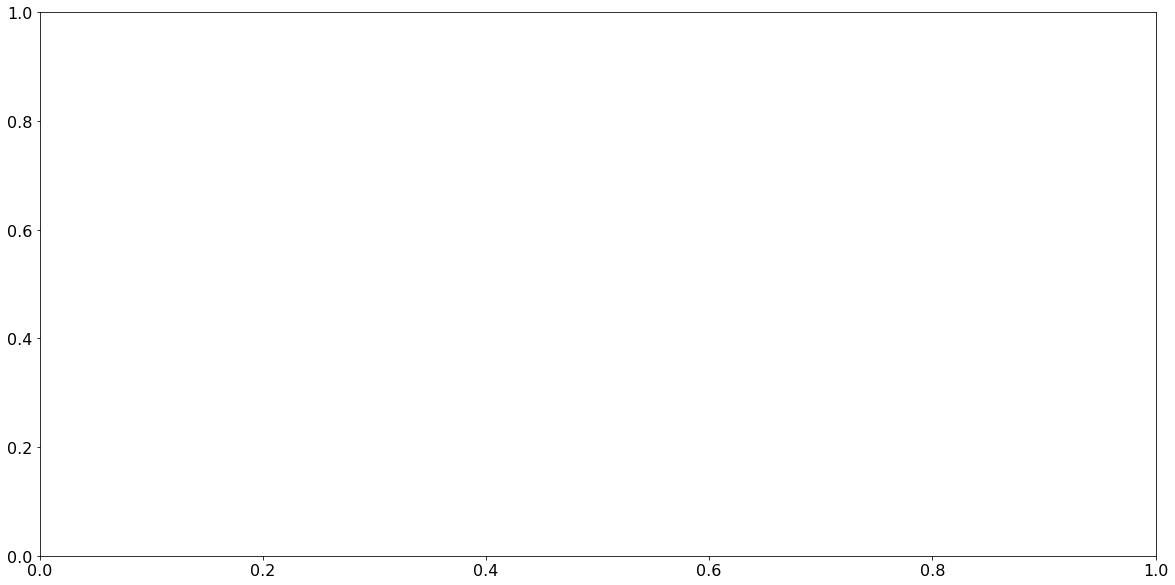

In [11]:

plot_model_performance(spectra_X, tau, estimator.predict(spectra), 'Tau', scores=scores, save_fig=True)


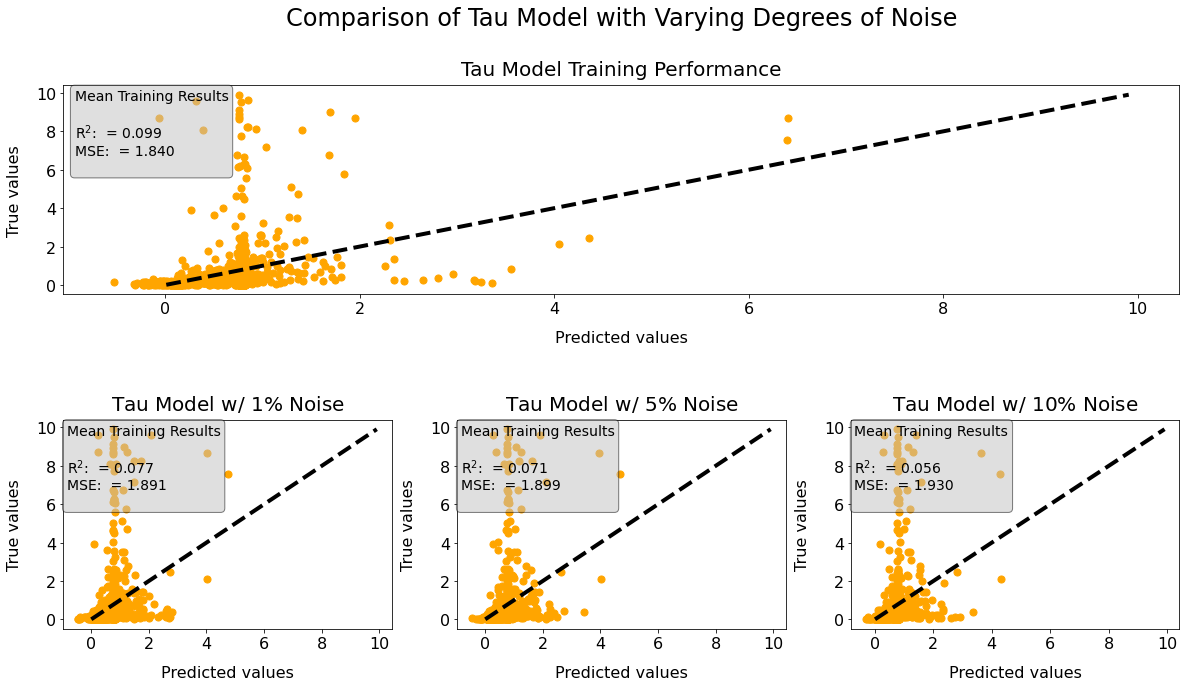

In [12]:
plot_noise_together(tau_model, tau, "Tau", cv)

## Predicting Mass

ValueError: x and y must be the same size

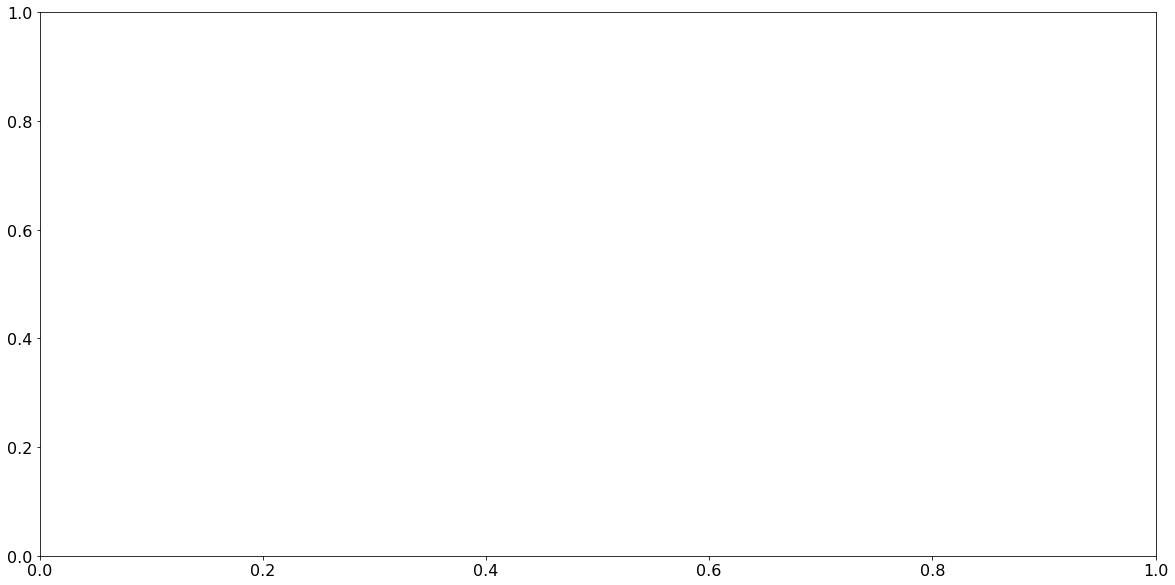

In [14]:

mass = galaxy_properties['mass']
visualize(mass, 'Mass', 'Mass Visualization', save_fig=True)

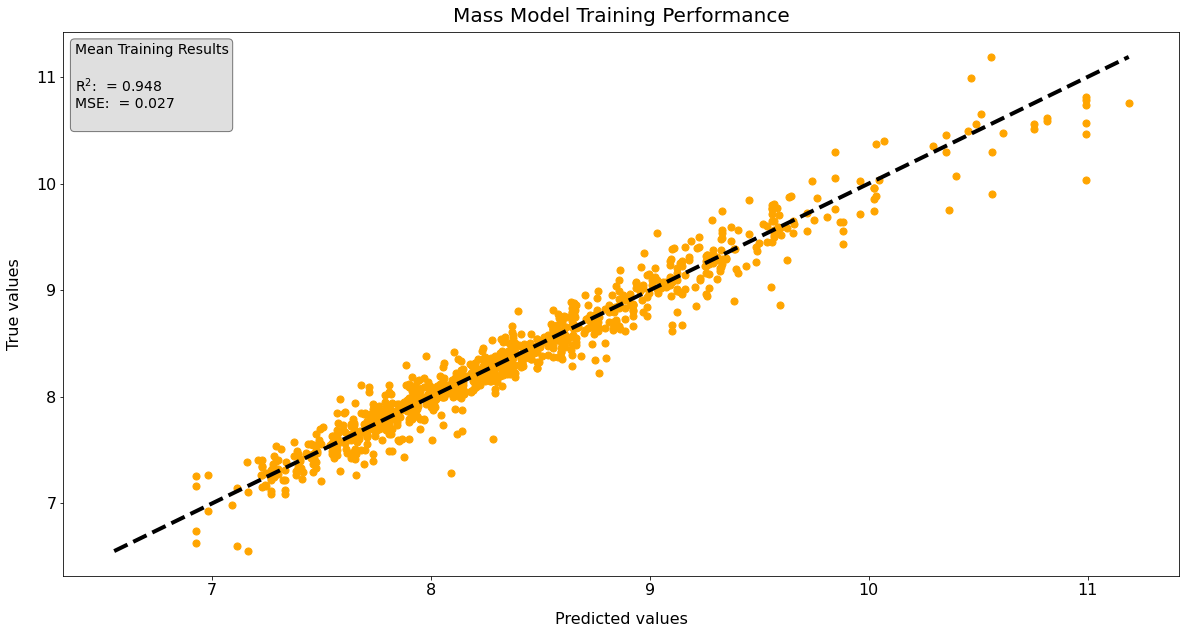

In [15]:
from sklearn.tree import DecisionTreeRegressor

mass_model = DecisionTreeRegressor(max_features=803)
cv_scores = cross_validate(mass_model, spectra, mass, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(mass_model, spectra, mass, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(mass, prediction, label='Mass', scores=scores, save_fig=True)

ValueError: x and y must be the same size

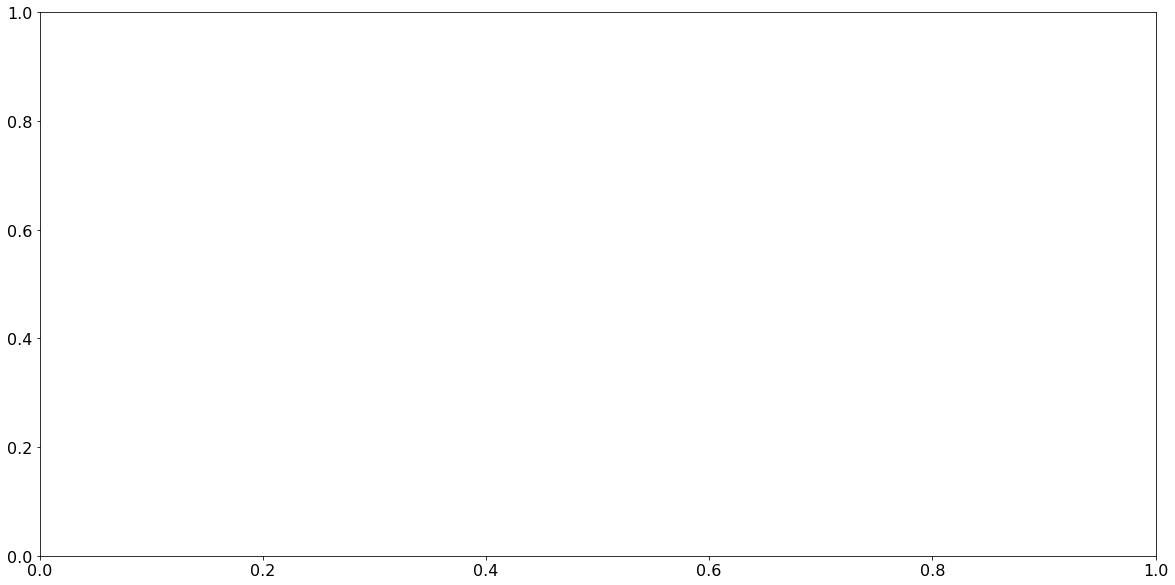

In [16]:
plot_model_performance(spectra_X, mass, estimator.predict(spectra), 'Mass', scores=scores, scores_loc=(0.01, 0.90), save_fig=True)


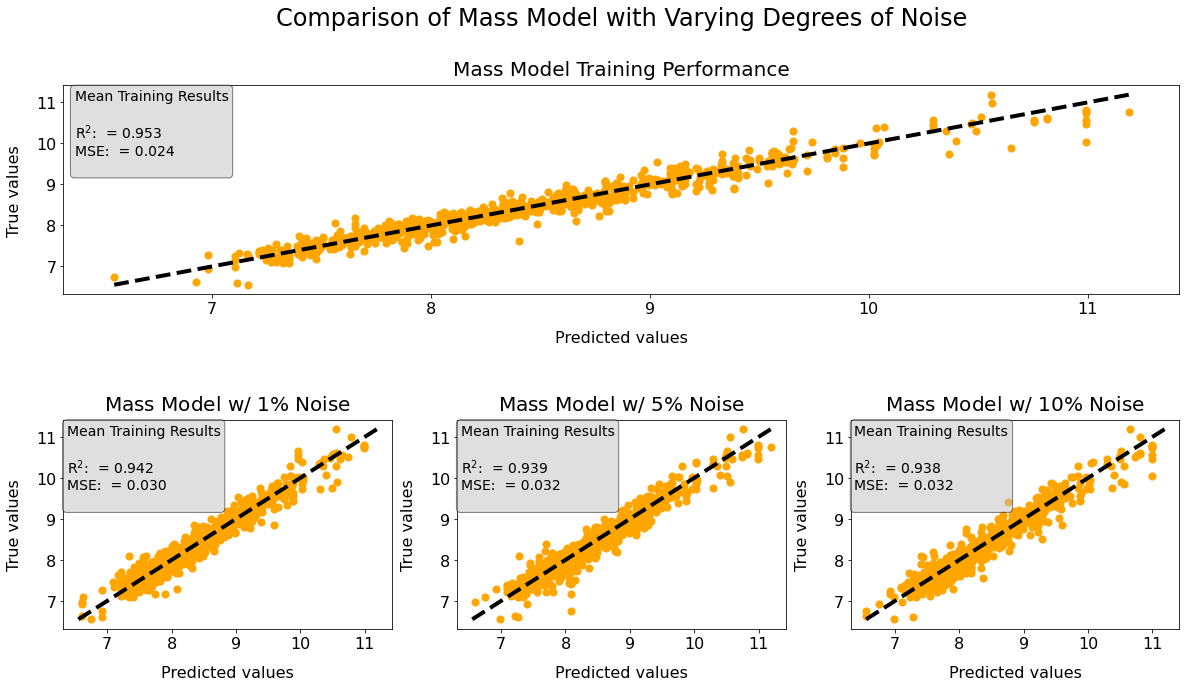

In [17]:
plot_noise_together(mass_model, mass, "Mass", cv)


## Predicting Dust

ValueError: x and y must be the same size

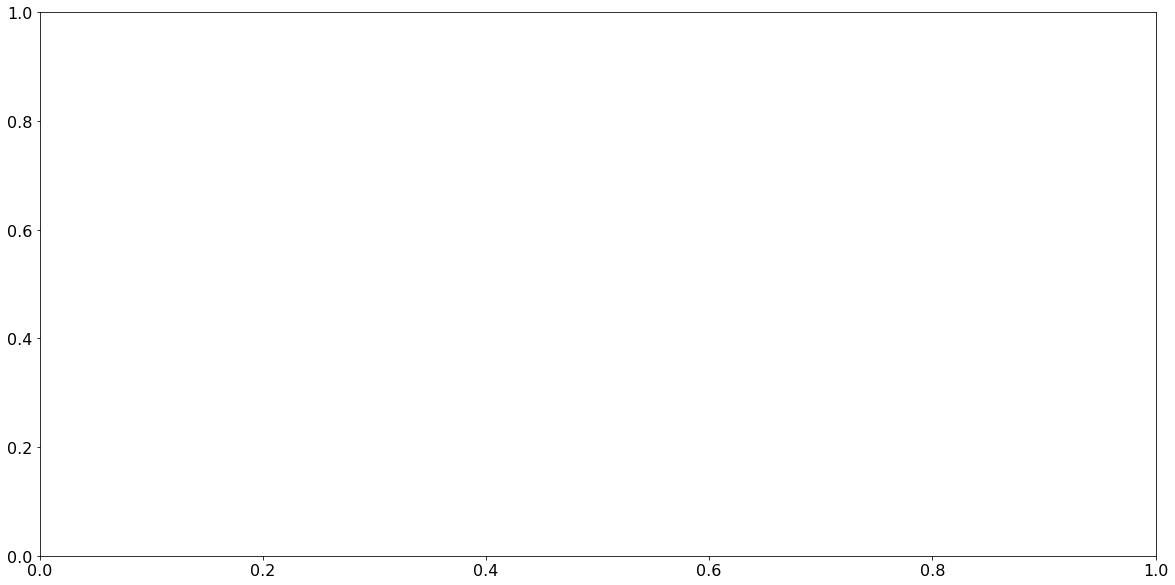

In [18]:
dust = galaxy_properties['dust_av']
visualize(dust, 'Dust', 'Dust Visualization', save_fig=True)


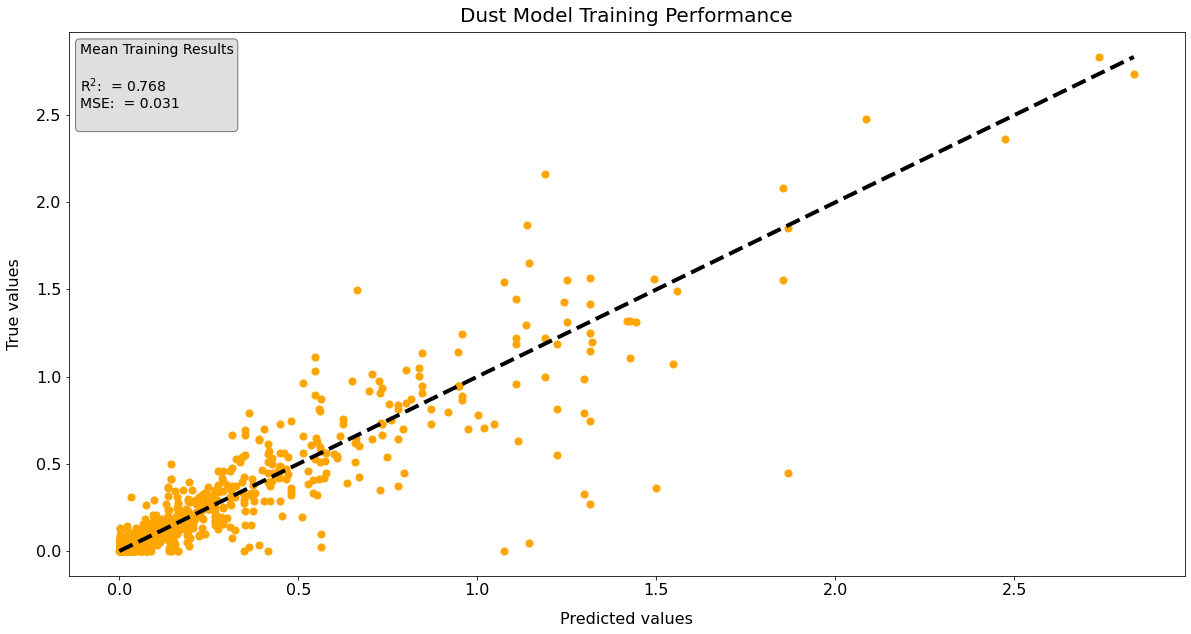

In [19]:

dust_model = DecisionTreeRegressor(max_features=800)
cv_scores = cross_validate(dust_model, spectra, dust, cv=cv, scoring=['r2', 'neg_mean_squared_error'], n_jobs=-1, return_estimator=True)
prediction = cross_val_predict(dust_model, spectra, dust, cv=cv, n_jobs=-1)

estimator = cv_scores['estimator'][cv_scores['test_r2'].argmax()]

scores = {
     '$\mathrm{R}^2$: ': np.mean(cv_scores['test_r2']),
     'MSE: ': np.abs(np.mean(cv_scores['test_neg_mean_squared_error']))
}

plot_model_training_performance(dust, prediction, label='Dust', scores=scores, save_fig=True)

ValueError: x and y must be the same size

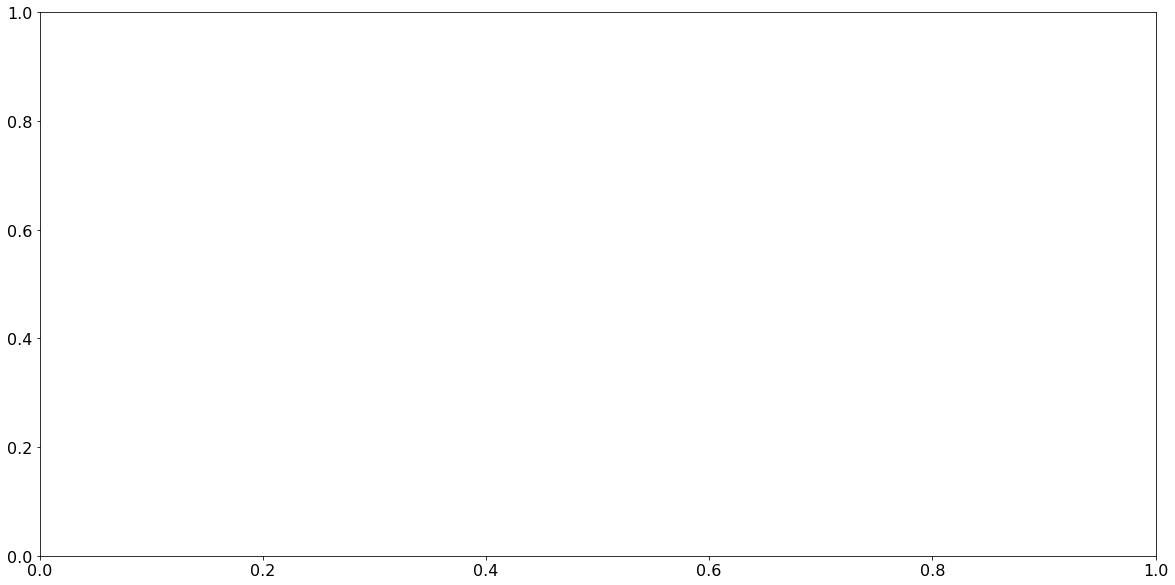

In [20]:

plot_model_performance(spectra_X, dust, estimator.predict(spectra), 'Dust', scores=scores, save_fig=True)

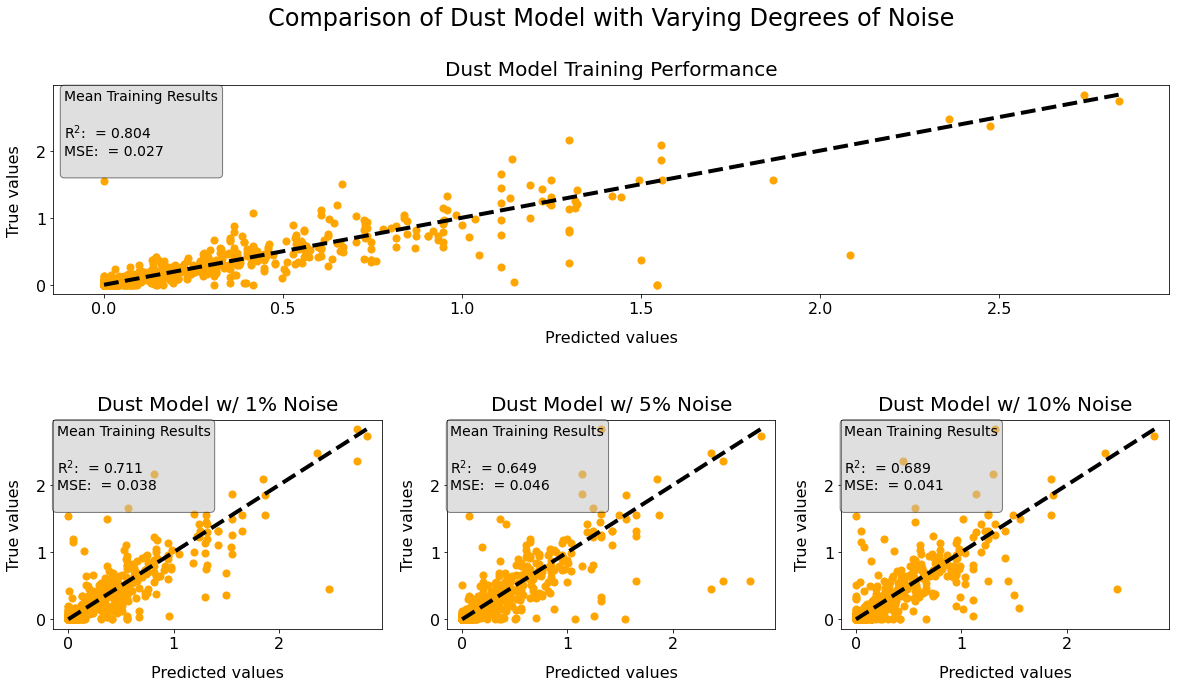

In [21]:
plot_noise_together(dust_model, dust, "Dust", cv)

## Conclusion
Adding noise levels does not improve the algorithm’s ability to predict properties. We could get better results by using more advanced machine learning techniques like a combination of convolutional neural networks and advanced simulations. Since we’ve figured that this simulated data is coming from an extensive series of images of a galaxy. According to our results, spectral energy distribution graphs do a good job at predicting mass, age and dust, but are not very helpful for obtaining tau. Additional data and formulas would help our models provide a better and accurate prediction for tau.